In [1]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

from torch.utils.data import DataLoader, Subset
from torch import optim
from torchvision import transforms, datasets

/work/LAS/mdhuai-lab/wqi/grad/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup GPU Device

In [2]:
if torch.cuda.is_available():
    #args.device = torch.device("cuda")
    cudnn.benchmark = True
    device = "cuda:0"
else:
    device = "cpu"
print(f'device: {device}')

!nvidia-smi

device: cuda:0
Sun Sep 21 19:55:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:45:00.0 Off |                    0 |
| N/A   45C    P0             57W /  300W |       4MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+--------------------------------

## Load Dataset

In [3]:
# Load CIFAR-10 dataset
data_mean = (0.4914, 0.4822, 0.4465)
data_std = (0.2023, 0.1994, 0.2010)
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std), ])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

num_classes = 10
batch_size = 128

# Dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print(f'Training data length: {len(train_data)}, test data length: {len(test_data)}')

# Get a single batch of data
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

print(f'Training batch shape: {train_images.shape}, testing batch shape: {test_images.shape}')

Files already downloaded and verified
Files already downloaded and verified
Training data length: 50000, test data length: 10000
Training batch shape: torch.Size([128, 3, 32, 32]), testing batch shape: torch.Size([128, 3, 32, 32])


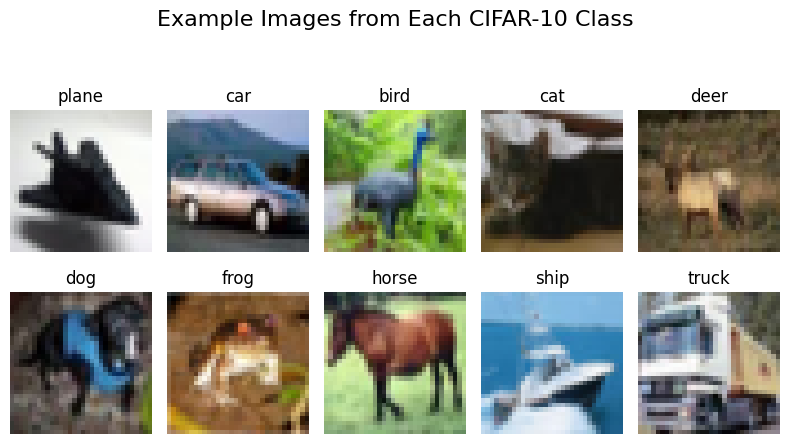

In [4]:
# Class names for CIFAR-10
class_names = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

images_to_plot = {}
for image, label in train_data:
    if label not in images_to_plot:
        images_to_plot[label] = image
    if len(images_to_plot) == 10:
        break

# Create example figures
fig, axes = plt.subplots(2, 5, figsize=(8, 5))
fig.suptitle('Example Images from Each CIFAR-10 Class', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(class_names):
        img_tensor = images_to_plot[i]
        img_unnormalized = img_tensor * torch.tensor(data_std).view(3, 1, 1) + torch.tensor(data_mean).view(3, 1, 1)
        img_unnormalized = img_unnormalized.numpy().transpose((1, 2, 0))
        img_unnormalized = np.clip(img_unnormalized, 0, 1)

        ax.imshow(img_unnormalized)
        ax.set_title(class_names[i])
        ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Load Model

In [5]:
# Build a simple convolutional neural networks
model = nn.Sequential(
            # First convolutional layer: takes a 3-channel image and outputs 16 feature maps
            # Kernel size is 4x4, stride is 2, and padding of 1 maintains output size
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),  # Activation function to introduce non-linearity

            # Second convolutional layer: takes 16 feature maps and outputs 32 feature maps
            # This layer learns more complex features
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),  # Another activation function

            # Average pooling layer: reduces the spatial dimensions by averaging over a 2x2 window
            # This makes the model more robust to small translations in the input
            nn.AvgPool2d(kernel_size=2, stride=2),

            # Dropout layer: randomly sets 40% of input neurons to zero during training
            # This prevents overfitting by forcing the model to rely on different neurons
            nn.Dropout(0.4),

            # Flatten layer: reshapes the multi-dimensional output from the convolutional layers
            # into a single long vector for the fully connected layers
            nn.Flatten(),

            # First fully connected (linear) layer: takes the flattened vector (512 features)
            # and outputs a vector of 128 features
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),  # Activation function

            # Output layer: a fully connected layer that maps the 128 features
            # to 10 classes, corresponding to the CIFAR-10 categories
            nn.Linear(in_features=128, out_features=10)
        )

# Move the model to the specified device (e.g., GPU)
model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Dropout(p=0.4, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)


## Train Model

In [6]:
epochs = 20 # Training epochs
lr = 0.01 # Learning rate

# Loss function
loss_func = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

def train(model, train_loader, loss_func, optimizer, epochs):
    model.train()
    loss_all = []
    for epoch in range(epochs):
        model.train()
        running_loss, n_batches, total, correct = 0.0, 0, 0, 0
    
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            n_batches += 1
    
        loss = running_loss / n_batches
        accuracy = 100 * correct / total
        print('Epoch %d training loss: %.3f training accuracy: %.3f%%' % (epoch, loss, accuracy))
    
        loss_all.append(loss)

    return loss_all

loss_all = train(model, train_loader, loss_func, optimizer, epochs)

Epoch 0 training loss: 1.895 training accuracy: 31.038%
Epoch 1 training loss: 1.519 training accuracy: 45.002%
Epoch 2 training loss: 1.407 training accuracy: 49.626%
Epoch 3 training loss: 1.336 training accuracy: 52.336%
Epoch 4 training loss: 1.274 training accuracy: 54.646%
Epoch 5 training loss: 1.228 training accuracy: 56.248%
Epoch 6 training loss: 1.193 training accuracy: 57.736%
Epoch 7 training loss: 1.150 training accuracy: 59.110%
Epoch 8 training loss: 1.121 training accuracy: 60.044%
Epoch 9 training loss: 1.092 training accuracy: 61.140%
Epoch 10 training loss: 1.066 training accuracy: 62.332%
Epoch 11 training loss: 1.040 training accuracy: 62.944%
Epoch 12 training loss: 1.027 training accuracy: 63.450%
Epoch 13 training loss: 1.011 training accuracy: 64.336%
Epoch 14 training loss: 0.985 training accuracy: 64.984%
Epoch 15 training loss: 0.965 training accuracy: 65.790%
Epoch 16 training loss: 0.953 training accuracy: 66.438%
Epoch 17 training loss: 0.940 training ac

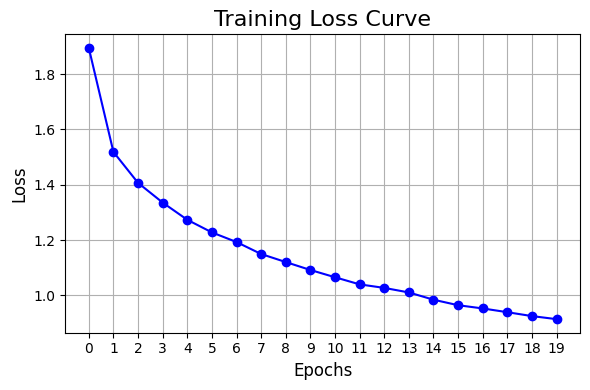

In [7]:
# Plot the loss curve
x_axis = np.arange(epochs)

plt.figure(figsize=(6, 4))
plt.plot(x_axis, loss_all, marker='o', linestyle='-', color='b')
plt.title('Training Loss Curve', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.xticks(x_axis) # Ensure integer epochs are shown
plt.tight_layout()

In [8]:
# Test the model
def test(model, test_loader):
    model.eval()
    total, correct = 0, 0
    
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total

acc = test(model, test_loader)
print('Test accuracy: %.2f%%' % (100 * acc))

Test accuracy: 69.25%


## Unlearn

In [9]:
# Random data-wise unlearning
num_samples = len(train_data)
sample_size = int(num_samples * 0.1)  # For example, 10% of the dataset

indices = list(range(num_samples))
unlearn_indices = random.sample(indices, sample_size)
unlearn_data = Subset(train_data, unlearn_indices)

retain_indices = [idx for idx in range(num_samples) if idx not in unlearn_indices]
retain_data = Subset(train_data, retain_indices)

unlearn_loader = DataLoader(unlearn_data, batch_size=128, shuffle=False)
retain_loader = DataLoader(retain_data, batch_size=128, shuffle=True)
print(f'Unlearn data length: {len(unlearn_data)}, remaning data length: {len(retain_data)}')

Unlearn data length: 5000, remaning data length: 45000


In [10]:
# First-order based unlearning
def get_grad_diff(model, unlearn_loader):
    loss_func = nn.CrossEntropyLoss(reduction="sum")
    model.train()
    grads = []

    for i, (images, labels) in enumerate(unlearn_loader):
        images, labels = images.to(device), labels.to(device)

        result_z = model(images)
        loss_z = loss_func(result_z, labels)
        loss_diff = -loss_z

        differentiable_params = [p for p in model.parameters() if p.requires_grad]
        gradients = torch.autograd.grad(loss_diff, differentiable_params)
        grads.append(gradients)

    # add all grads from batch
    grads = list(zip(*grads))
    for i in range(len(grads)):
        tmp = grads[i][0]
        for j in range(1, len(grads[i])):
            tmp = torch.add(tmp, grads[i][j])
        grads[i] = tmp

    return grads

def first_order_unlearn(model, unlearn_loader, tau=0.00002):
    net_unlearn = copy.deepcopy(model)
    diff = get_grad_diff(net_unlearn, unlearn_loader)
    d_theta = diff

    net_unlearn.eval()
    with torch.no_grad():
        for p in net_unlearn.parameters():
            if p.requires_grad:
                new_p = p - tau * d_theta.pop(0)
                p.copy_(new_p)

    return net_unlearn

In [11]:
# Test unlearn performance
net_unlearn = first_order_unlearn(model, unlearn_loader)

unlearn_acc_org = test(model, unlearn_loader)
unlearn_acc = test(net_unlearn, unlearn_loader)
retain_acc = test(net_unlearn, retain_loader)
print(f'Unlearn data accuracy original: {100 * unlearn_acc_org:.2f}%, unlearn data accuracy: {100 * unlearn_acc:.2f}%, retain data accuracy: {100 * retain_acc:.2f}%')

Unlearn data accuracy original: 75.78%, unlearn data accuracy: 72.28%, retain data accuracy: 72.04%


In [12]:
# Random class-wise unlearning
class_labels = list(range(num_classes))

unlearn_class_label = random.choice(class_labels)
print(f"Randomly selected class for unlearning: {unlearn_class_label}")

unlearn_indices = [idx for idx, (image, label) in enumerate(train_data) if label == unlearn_class_label]
unlearn_class_data = Subset(train_data, unlearn_indices)

retain_indices = [idx for idx in range(num_samples) if idx not in unlearn_indices]
retain_class_data = Subset(train_data, retain_indices)

unlearn_class_loader = DataLoader(unlearn_class_data, batch_size=128, shuffle=False)
retain_class_loader = DataLoader(retain_class_data, batch_size=128, shuffle=True)
print(f'Unlearn data length: {len(unlearn_data)}, remaning data length: {len(retain_data)}')

Randomly selected class for unlearning: 4
Unlearn data length: 5000, remaning data length: 45000


In [13]:
# Test unlearn performance
net_unlearn = first_order_unlearn(model, unlearn_class_loader)

unlearn_acc_org = test(model, unlearn_class_loader)
unlearn_acc = test(net_unlearn, unlearn_class_loader)
retain_acc = test(net_unlearn, retain_class_loader)
print(f'Unlearn data accuracy original: {100 * unlearn_acc_org:.2f}%, unlearn data accuracy: {100 * unlearn_acc:.2f}%, retain data accuracy: {100 * retain_acc:.2f}%')

Unlearn data accuracy original: 75.76%, unlearn data accuracy: 0.00%, retain data accuracy: 70.67%


In [14]:
# Fine-tuning based unlearning
def finetune(model, retain_loader, lr=0.1, epochs=5):
    net_unlearn = copy.deepcopy(model)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net_unlearn.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

    train(net_unlearn, retain_loader, loss_func, optimizer, epochs)

    return net_unlearn

In [15]:
# Test unlearn performance
net_unlearn = finetune(model, retain_loader)

unlearn_acc_org = test(model, unlearn_loader)
unlearn_acc = test(net_unlearn, unlearn_loader)
retain_acc = test(net_unlearn, retain_loader)
print(f'Unlearn data accuracy original: {100 * unlearn_acc_org:.2f}%, unlearn data accuracy: {100 * unlearn_acc:.2f}%, retain data accuracy: {100 * retain_acc:.2f}%')

net_unlearn = finetune(model, retain_class_loader)

unlearn_acc_org = test(model, unlearn_class_loader)
unlearn_acc = test(net_unlearn, unlearn_class_loader)
retain_acc = test(net_unlearn, retain_class_loader)
print(f'Unlearn data accuracy original: {100 * unlearn_acc_org:.2f}%, unlearn data accuracy: {100 * unlearn_acc:.2f}%, retain data accuracy: {100 * retain_acc:.2f}%')

Epoch 0 training loss: 1.459 training accuracy: 48.040%
Epoch 1 training loss: 1.375 training accuracy: 51.304%
Epoch 2 training loss: 1.314 training accuracy: 53.758%
Epoch 3 training loss: 1.293 training accuracy: 54.553%
Epoch 4 training loss: 1.254 training accuracy: 55.887%
Unlearn data accuracy original: 75.78%, unlearn data accuracy: 59.92%, retain data accuracy: 62.88%
Epoch 0 training loss: 1.391 training accuracy: 50.027%
Epoch 1 training loss: 1.272 training accuracy: 54.589%
Epoch 2 training loss: 1.214 training accuracy: 56.531%
Epoch 3 training loss: 1.179 training accuracy: 57.589%
Epoch 4 training loss: 1.163 training accuracy: 58.487%
Unlearn data accuracy original: 75.76%, unlearn data accuracy: 0.00%, retain data accuracy: 64.70%


In [16]:
# Random perturbation-wise unlearning
eps = 16 # Perturbation bound

ds = torch.tensor(data_std)[None, :, None, None]
init = torch.randn(len(unlearn_indices), *train_data[0][0].shape)
init *= eps / ds / 255
init.data = torch.max(torch.min(init, eps / ds / 255), -eps / ds / 255)

unlearn_delta = init.to(device)

In [17]:
# First-order based unlearning
def get_grad_diff_partial(model, base_loader, unlearn_delta, batch_size=128):
    loss_func = nn.CrossEntropyLoss(reduction="sum")
    model.train()
    grads = []

    for i, (images, labels) in enumerate(base_loader):
        images, labels = images.to(device), labels.to(device)
    
        result_z = model(images)
        loss_z = loss_func(result_z, labels)
        # print(loss_z)
    
        result_z_delta = model(torch.add(images, unlearn_delta[i * batch_size : i * batch_size + len(images)]))
        loss_z_delta = loss_func(result_z_delta, labels)
        # print(loss_z_delta)
    
        loss_diff = loss_z_delta - loss_z
    
        differentiable_params = [p for p in model.parameters() if p.requires_grad]
        gradients = torch.autograd.grad(loss_diff, differentiable_params)
        grads.append(gradients)

    # add all grads from batch
    grads = list(zip(*grads))
    for i in range(len(grads)):
        tmp = grads[i][0]
        for j in range(1, len(grads[i])):
            tmp = torch.add(tmp, grads[i][j])
        grads[i] = tmp

    return grads

def first_order_unlearn_partial(model, base_loader, unlearn_delata, tau=0.00002):
    net_unlearn = copy.deepcopy(model)
    diff = get_grad_diff_partial(net_unlearn, base_loader, unlearn_delta)
    d_theta = diff

    net_unlearn.eval()
    with torch.no_grad():
        for p in net_unlearn.parameters():
            if p.requires_grad:
                new_p = p - tau * d_theta.pop(0)
                p.copy_(new_p)

    return net_unlearn

In [18]:
# Test unlearn performance
net_unlearn = first_order_unlearn_partial(model, unlearn_loader, unlearn_delta)

unlearn_acc_org = test(model, unlearn_loader)
unlearn_acc = test(net_unlearn, unlearn_loader)
retain_acc = test(net_unlearn, retain_loader)
print(f'Unlearn data accuracy original: {100 * unlearn_acc_org:.2f}%, unlearn data accuracy: {100 * unlearn_acc:.2f}%, retain data accuracy: {100 * retain_acc:.2f}%')

Unlearn data accuracy original: 75.78%, unlearn data accuracy: 74.80%, retain data accuracy: 74.62%
